In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm
from pycocotools import coco
from pprint import pprint
import datetime

BATCH_SIZE = 2
IMAGE_SIZE = (256, 384)
BBOX_FORMAT = "xywh"
AUTOTUNE = tf.data.AUTOTUNE
MAX_EPOCHS = 300
PATIENCE = 50
INITIAL_EPOCH = 0
LOAD_MODEL = ""
BACKBONE_PRESET = "yolo_v8_s_backbone_coco"
SAVE_LABEL = "yolov8_small"

train_annotations = "label_data/label_kaggle_training/result.json"
train_images = "label_data/label_kaggle_training/images"
coco_train = coco.COCO(train_annotations)

val_annotations = "label_data/label_kaggle_test/result.json"
val_images = "label_data/label_kaggle_test/images"
coco_val = coco.COCO(val_annotations)

categories = coco_train.loadCats(coco_train.getCatIds())
class_map = {category["id"]: category["name"] for category in categories}

pprint(class_map)

if LOAD_MODEL:
    print(f"Loading existing model from {LOAD_MODEL}")
    model = keras.models.load_model(LOAD_MODEL)
else:
    print("Training new model")
    model = keras_cv.models.YOLOV8Detector.from_preset(
        preset=BACKBONE_PRESET,
        bounding_box_format=BBOX_FORMAT,
        num_classes=len(class_map),
    )
    INITIAL_EPOCH = 0

2024-04-28 19:04:13.266620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dino/miniconda3/envs/picar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{0: 'box',
 1: 'green_light',
 2: 'left_arrow',
 3: 'no_light',
 4: 'person',
 5: 'red_light',
 6: 'right_arrow',
 7: 'tree',
 8: 'unknown_arrow'}
Training new model


2024-04-28 19:04:18.683174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 19:04:18.815645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 19:04:18.815902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 19:04:18.818461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 19:04:18.818752: I external/local_xla/xla/stream_executor

In [2]:
def getAnnotations(coco_instance, image_id):
    ann_ids = coco_instance.getAnnIds(imgIds=[image_id])
    anns = coco_instance.loadAnns(ann_ids)

    bboxes = []
    category_ids = []

    for ann in anns:
        bbox = ann["bbox"]
        category_id = ann["category_id"]

        bboxes.append(bbox)
        category_ids.append(category_id)

    return {"boxes": bboxes, "classes": category_ids}


def loadImage(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, IMAGE_SIZE) # Screws up bounding boxes, we'll add it as a preprocessing layer
    image = tf.cast(image, tf.float32)
    return image


def loadDatapaths(coco_instance, image_dir):
    img_ids = coco_instance.getImgIds()
    img_paths = []
    boxes = []
    classes = []

    for img_id in img_ids:
        img = coco_instance.loadImgs(img_id)[0]
        img_path = os.path.join(image_dir, img["file_name"])

        annotations = getAnnotations(coco_instance, img_id)

        if len(annotations["boxes"]) > 0 and len(annotations["classes"]) > 0:
            img_paths.append(img_path)
            boxes.append(annotations["boxes"])
            classes.append(annotations["classes"])

    return img_paths, boxes, classes


def loadDatapoint(img_path, boxes, classes):
    image = loadImage(img_path)
    bbox = {"boxes": boxes, "classes": classes}
    return {"images": image, "bounding_boxes": bbox}


def loadDataset(coco_instance, image_dir):
    img_paths, boxes, classes = loadDatapaths(coco_instance, image_dir)
    img_paths = tf.ragged.constant(img_paths)
    boxes = tf.ragged.constant(boxes)
    classes = tf.ragged.constant(classes)

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, boxes, classes))
    dataset = dataset.map(loadDatapoint, num_parallel_calls=AUTOTUNE)
    dataset = dataset.ragged_batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.shuffle(8 * BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

In [3]:
train_dataset = loadDataset(coco_train, train_images)
val_dataset = loadDataset(coco_val, val_images)

In [4]:
def visualiseDataset(
    inputs, value_range=(0, 255), rows=1, cols=2, bounding_box_format=BBOX_FORMAT
):
    inputs = next(iter(inputs.take(1)))
    images = inputs["images"]
    bounding_boxes = inputs["bounding_boxes"]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_map,
    )

Number of training batches: 2437


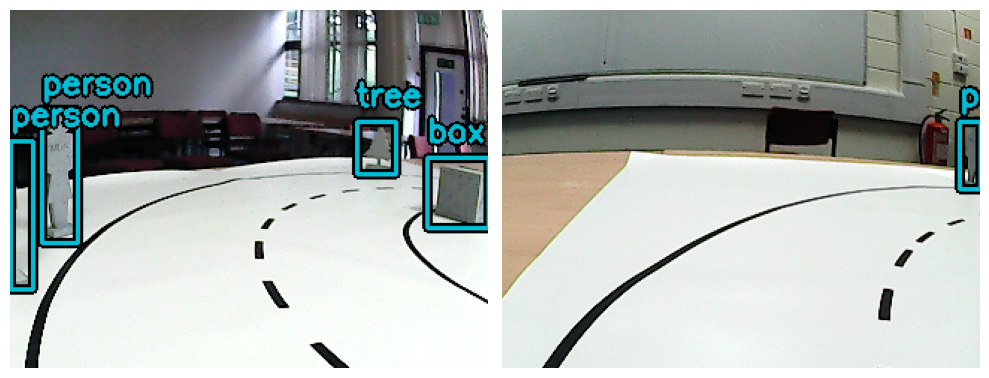

In [5]:
print("Number of training batches: {}".format(len(train_dataset)))
visualiseDataset(train_dataset)

In [6]:
# layers = keras_cv.layers.RandAugment.get_standard_policy(
#    value_range=(0, 255),
#    magnitude=0.2,
#    magnitude_stddev=0.15,
#    geometric=False,
# )
# pprint(layers)

# layers.pop(1)
# layers.pop(1)

# pprint(layers)
layers = [keras_cv.layers.RandomBrightness(value_range=(0, 255), factor=0.2)]
layers = layers + [keras_cv.layers.RandomContrast(value_range=(0, 255), factor=0.2)]
# layers = layers + [keras_cv.layers.RandomColorDegeneration(factor=0.2)]
layers = layers + [keras_cv.layers.RandomHue(value_range=(0, 255), factor=0.2)]
layers = layers + [keras_cv.layers.RandomSaturation(factor=0.2)]

pprint(layers)

pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers,
    augmentations_per_image=2,
    rate=0.5,
)

[<RandomBrightness name=random_brightness, built=False>,
 <RandomContrast name=random_contrast, built=False>,
 <RandomHue name=random_hue, built=False>,
 <RandomSaturation name=random_saturation, built=False>]


2024-04-28 19:04:22.703445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node random_augmentation_pipeline_1_map_while_cond_1_false_3812}}{{node random_augmentation_pipeline_1/map/while/cond_1/random_choice_1/stateful_uniform/RngReadAndSkip}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-04-28 19:04:22.703536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7185261106706177808
2024-04-28 19:04:22.703546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 381352571091995404
2024-04-28 19:04:22.703558: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16962108989323010199
2024-04-28 19:04:22.703567: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15258661514103968091
2024-04-

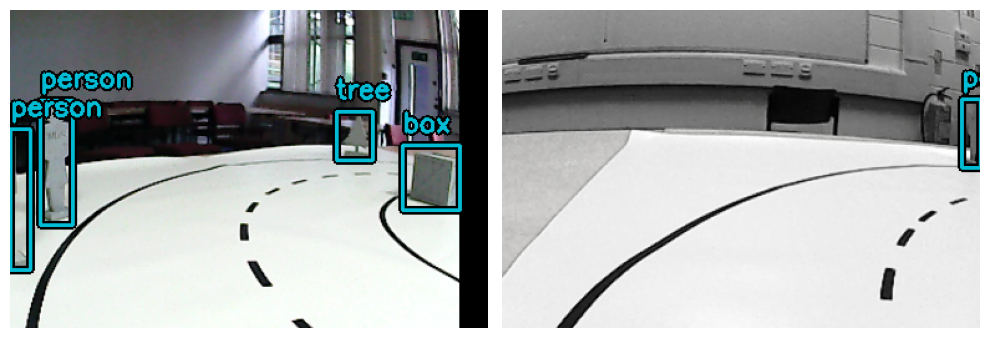

In [7]:
# TODO: Try MixUp
bbox_augmenters = [
    keras_cv.layers.JitteredResize(
        target_size=IMAGE_SIZE,
        scale_factor=(0.75, 1.3),
        bounding_box_format=BBOX_FORMAT,
    )
]

# image_augmenters = [keras_cv.layers.RandAugment(value_range=(0, 255), geometric=False, magnitude=0.3)]
image_augmenters = [pipeline]


def createAugmenterFunction(augmenters):
    def augmenterFunction(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenterFunction


bbox_augmenter = createAugmenterFunction(bbox_augmenters)
image_augmenter = createAugmenterFunction(image_augmenters)

train_dataset = train_dataset.map(bbox_augmenter, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(
    lambda x: {
        "images": image_augmenter(x["images"]),
        "bounding_boxes": x["bounding_boxes"],
    },
    num_parallel_calls=AUTOTUNE,
)

visualiseDataset(train_dataset)

In [8]:
validation_resizing = keras_cv.layers.Resizing(
    height=IMAGE_SIZE[0],
    width=IMAGE_SIZE[1],
    bounding_box_format=BBOX_FORMAT,
    pad_to_aspect_ratio=True,
)

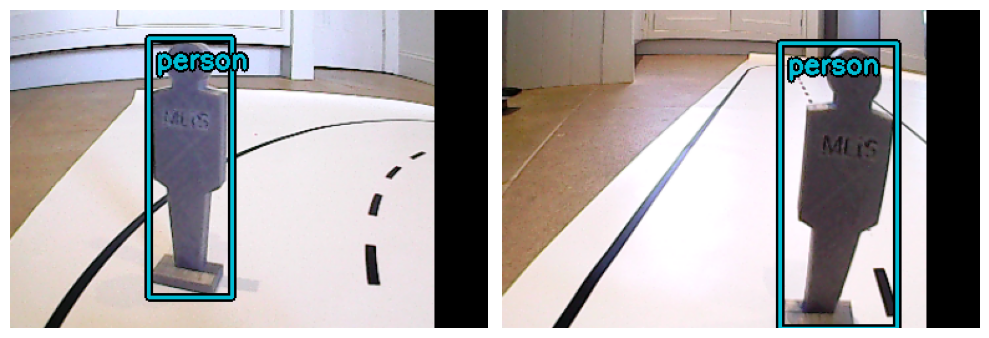

In [9]:
val_dataset = val_dataset.map(validation_resizing, num_parallel_calls=AUTOTUNE)

visualiseDataset(val_dataset)

In [10]:
# To be TPU compatible, bounding box tensors must be Dense, not Ragged
def dictToTuple(inputs):
    return (
        inputs["images"],
        keras_cv.bounding_box.to_dense(inputs["bounding_boxes"], max_boxes=32),
    )


train_dataset = train_dataset.map(dictToTuple, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(dictToTuple, num_parallel_calls=AUTOTUNE)

In [11]:
# TODO: Hand-make a PiecewiseConstantDecay schedule
base_lr = 0.005
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [12]:
model.compile(
    classification_loss="binary_crossentropy", box_loss="ciou", optimizer=optimizer
)

In [13]:
class StopIfAboveThreshold(keras.callbacks.Callback):
    def __init__(self, check_epoch, loss, monitor="val_loss", mode="min"):
        super(StopIfAboveThreshold, self).__init__()
        self.check_epoch = check_epoch
        self.loss = loss
        self.monitor = monitor
        self.mode = mode

    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.check_epoch:
            current_loss = logs.get(self.monitor)
            if current_loss is not None:
                if self.mode == "min" and current_loss > self.loss:
                    self.model.stop_training = True
                elif self.mode == "max" and current_loss < self.loss:
                    self.model.stop_training = True

In [14]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format=BBOX_FORMAT,
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [15]:
timestamp = datetime.datetime.now().strftime("%s")
callbacks = [
    # keras_cv.callbacks.PyCOCOCallback(
    #    validation_data=val_dataset,
    #    bounding_box_format=BBOX_FORMAT,
    # ),
    # keras.callbacks.ReduceLROnPlateau(
    #    factor=0.1,
    #    patience=3,
    #    min_lr=1e-6
    # ),
    # keras.callbacks.ModelCheckpoint(
    #    filepath=f"object_detection/{SAVE_LABEL}_{timestamp}.keras",
    #    save_best_only=True,
    #    monitor="val_loss",
    # ),
    EvaluateCOCOMetricsCallback(
        data=val_dataset, save_path=f"object_detection/{SAVE_LABEL}_{timestamp}.keras"
    ),
    keras.callbacks.EarlyStopping(
        patience=PATIENCE,
        restore_best_weights=True,
        monitor="val_loss",
        mode="min",
        start_from_epoch=(INITIAL_EPOCH + 5),
    ),
    keras.callbacks.TensorBoard(
        log_dir=f"object_detection/logs/{SAVE_LABEL}_{timestamp}", histogram_freq=1
    ),
    # StopIfAboveThreshold(check_epoch=5, loss=2)
]

In [16]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=MAX_EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    callbacks=callbacks,
)

Epoch 1/300


I0000 00:00:1714327482.640360    1383 service.cc:145] XLA service 0x7f6c54003930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714327482.640432    1383 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-04-28 19:04:43.524848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-28 19:04:45.012378: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1714327508.499447    1383 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_4', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1714327508.544666    1383 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2436/2437 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 75.1257

2024-04-28 19:07:16.241095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/dino/miniconda3/envs/picar/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `mAP` which is not available. Available metrics are: loss,val_loss,MaP,MaP@[IoU=50],MaP@[IoU=75],MaP@[area=small],MaP@[area=medium],MaP@[area=large],Recall@[max_detections=1],Recall@[max_detections=10],Recall@[max_detections=100],Recall@[area=small],Recall@[area=medium],Recall@[area=large]
  current = self.get_monitor_value(logs)


2437/2437 ━━━━━━━━━━━━━━━━━━━━ 175s 54ms/step - loss: 75.0767 - val_loss: 1.6168 - MaP: 0.8218 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 1.0000 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.8218 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.8500 - Recall@[max_detections=10]: 0.8500 - Recall@[max_detections=100]: 0.8500 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.8500 - Recall@[area=large]: 0.0000e+00
Epoch 2/300
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.6361

2024-04-28 19:09:19.887576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2437/2437 ━━━━━━━━━━━━━━━━━━━━ 123s 50ms/step - loss: 1.6361 - val_loss: 1.5531 - MaP: 0.1128 - MaP@[IoU=50]: 0.2039 - MaP@[IoU=75]: 0.1114 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.1091 - MaP@[area=large]: 0.2473 - Recall@[max_detections=1]: 0.1340 - Recall@[max_detections=10]: 0.1408 - Recall@[max_detections=100]: 0.1408 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1291 - Recall@[area=large]: 0.3182
Epoch 3/300
1098/2437 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - loss: 1.5589

KeyboardInterrupt: 

In [ ]:
best_val_loss = min(history.history["val_loss"])
best_val_loss_epoch = history.history["val_loss"].index(best_val_loss)

best_map = max(history.history["mAP"])
best_map_epoch = history.history["mAP"].index(best_map)

print(f"Best validation loss: {best_val_loss} at epoch {best_val_loss_epoch}")
print(f"Best mAP: {best_map} at epoch {best_map_epoch}")
# final_epoch = len(history.history["val_loss"])

# os.rename(
#    f"object_detection/{SAVE_LABEL}_{timestamp}.keras",
#    f"object_detection/{SAVE_LABEL}_{timestamp}_{best_val_loss}_{final_epoch}.keras",
# )

NameError: name 'history' is not defined

In [ ]:
!mkdir -p object_detection/exported
model.save(f"object_detection/exported/{SAVE_LABEL}_{timestamp}.keras")

In [ ]:
model2 = keras.models.load_model(
    "object_detection/exported/yolov8_small_1714174368.keras",
    custom_objects={"YOLOV8Detector": keras_cv.models.YOLOV8Detector},
)

In [ ]:
model.evaluate(val_dataset)

In [ ]:
model2.compile(
    classification_loss="binary_crossentropy", box_loss="ciou", optimizer=optimizer
)

# model2.evaluate(val_dataset)

In [ ]:
model2.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.3,
)

In [ ]:
import cv2

image = keras.utils.load_img("label_kaggle_test/images/0e87d07d-192.png")
image = np.array(image)
image = validation_resizing([image])


y_pred = model2.predict(image)
print(y_pred)

keras_cv.visualization.plot_bounding_box_gallery(
    image,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=BBOX_FORMAT,
    class_mapping=class_map,
)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=1,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_map,
    )


visualize_detections(model, dataset=val_dataset, bounding_box_format=BBOX_FORMAT)